In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [3]:
df_imp = pd.read_excel('IMPORTACION-VOLUMEN-2023-05.xlsx', sheet_name='IMPORTACION',skiprows = 6,
                            nrows=270, header=0,usecols= 'A, G, I, K, L, U', engine='openpyxl').dropna()

df_imp.head()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
0,2001-01-01,0.0,194065.738095,177776.50,373963.96,566101.99
1,2001-02-01,0.0,170703.380952,123115.99,243091.07,489525.80
2,2001-03-01,0.0,161837.371429,161726.42,312084.38,575559.68
3,2001-04-01,0.0,163048.642857,127338.74,285054.89,437745.42
4,2001-05-01,0.0,171518.861905,168730.19,300913.67,552609.13


In [4]:
df_imp.tail()

,Fecha,Diesel bajo azufre,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel alto azufre
264,2023-01-01,1442099.08,497780.69,909391.13,578792.14,0.0
265,2023-02-01,1267967.39,652984.71,725101.20,685183.06,0.0
266,2023-03-01,1317519.91,711978.35,803262.67,633849.05,0.0
267,2023-04-01,1417182.73,647666.30,922032.39,572201.36,0.0
268,2023-05-01,1428099.62,713348.99,947633.29,668478.73,0.0


In [5]:
(df_imp.iloc[:,1] != 0).idxmax(), (df_imp.iloc[:,5] == 0).idxmax() # las volumnas se pueden sumar en una sola

(204, 204)

In [6]:
df_imp['Diesel'] = df_imp['Diesel bajo azufre'] + df_imp['Diesel alto azufre']
df_imp.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [7]:
df_imp.info(), df_imp.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 268
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Fecha                    269 non-null    datetime64[ns]
 1   Gas licuado de petróleo  269 non-null    float64       
 2   Gasolina regular         269 non-null    float64       
 3   Gasolina superior        269 non-null    float64       
 4   Diesel                   269 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 12.6 KB


(None, (269, 5))

In [8]:
df_imp.describe().applymap(lambda x: f"{int(x):,}")

,Gas licuado de petróleo,Gasolina regular,Gasolina superior,Diesel
count,269,269,269,269
mean,"399,026","381,883","478,288","863,979"
std,"190,173","219,364","153,277","276,545"
min,"100,561","81,015","170,292","229,764"
25%,"218,257","201,907","363,352","678,749"
50%,"396,363","305,285","456,588","824,047"
75%,"540,671","528,347","582,374","1,050,560"
max,"960,840","987,872","1,227,173","1,595,698"


In [9]:
df_p_nac_1 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2021',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_1.drop(0, inplace=True)
df_p_nac_2 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2022',skiprows = 6,
                            nrows=366, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_2.drop(0, inplace=True)
df_p_nac_3 = pd.read_excel('Precios-Promedio-Nacionales-Diarios-2023.xlsx', sheet_name='2023',skiprows = 7,
                            nrows=213, header=0,usecols= 'A,C:E, G', engine='openpyxl')
df_p_nac_3.drop(0, inplace=True)

In [10]:
df_p_nac_1.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2021-01-01,21.91,21.11,17.61,99
2,2021-01-02,21.91,21.11,17.61,99
3,2021-01-03,21.91,21.11,17.61,99
4,2021-01-04,21.91,21.11,17.61,99
5,2021-01-05,21.91,21.11,17.61,99


In [11]:
df_p_nac_1.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
361,2021-12-27,28.69,27.91,24.51,122
362,2021-12-28,28.69,27.91,24.51,122
363,2021-12-29,28.69,27.91,24.51,122
364,2021-12-30,28.69,27.91,24.51,122
365,2021-12-31,28.69,27.91,24.51,122


In [12]:
df_p_nac_2.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2022-01-01,28.69,27.91,24.51,122
2,2022-01-02,28.69,27.91,24.51,122
3,2022-01-03,28.79,27.99,24.6,122
4,2022-01-04,28.79,27.99,24.6,122
5,2022-01-05,28.79,27.99,24.6,122


In [13]:
df_p_nac_2.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
361,2022-12-27,32.55,30.99,33.75,122
362,2022-12-28,32.55,30.99,33.75,122
363,2022-12-29,32.55,30.99,33.75,122
364,2022-12-30,32.55,30.99,33.75,122
365,2022-12-31,32.55,30.99,33.75,122


In [14]:
df_p_nac_3.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
1,2023-01-01,32.55,30.99,33.75,122
2,2023-01-02,32.55,30.99,33.75,122
3,2023-01-03,32.56,31.42,35.31,122
4,2023-01-04,32.56,31.42,35.31,122
5,2023-01-05,32.56,31.42,35.31,122


In [15]:
df_p_nac_3.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
208,2023-07-27,34.78,33.28,28.47,135
209,2023-07-28,34.78,33.28,28.47,135
210,2023-07-29,34.78,33.28,28.47,135
211,2023-07-30,34.78,33.28,28.47,135
212,2023-07-31,36.29,34.77,29.68,135


In [16]:
df_precios = pd.concat([df_p_nac_1, df_p_nac_2, df_p_nac_3], ignore_index=True)
df_precios.head()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
0,2021-01-01,21.91,21.11,17.61,99
1,2021-01-02,21.91,21.11,17.61,99
2,2021-01-03,21.91,21.11,17.61,99
3,2021-01-04,21.91,21.11,17.61,99
4,2021-01-05,21.91,21.11,17.61,99


In [17]:
df_precios.tail()

,FECHA,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
937,2023-07-27,34.78,33.28,28.47,135
938,2023-07-28,34.78,33.28,28.47,135
939,2023-07-29,34.78,33.28,28.47,135
940,2023-07-30,34.78,33.28,28.47,135
941,2023-07-31,36.29,34.77,29.68,135


In [18]:
df_precios.info(), df_precios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                942 non-null    datetime64[ns]
 1   Superior             942 non-null    object        
 2   Regular              942 non-null    object        
 3   Diesel               942 non-null    object        
 4   Glp Cilindro 25Lbs.  942 non-null    object        
dtypes: datetime64[ns](1), object(4)
memory usage: 36.9+ KB


(None, (942, 5))

In [19]:
columnas_precios = list(df_precios.columns[1:])
columnas_precios

['Superior', 'Regular', 'Diesel', 'Glp Cilindro 25Lbs.']

In [20]:
df_precios[columnas_precios] = df_precios[columnas_precios].astype(float)
df_precios.info(), df_precios.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 942 entries, 0 to 941
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   FECHA                942 non-null    datetime64[ns]
 1   Superior             942 non-null    float64       
 2   Regular              942 non-null    float64       
 3   Diesel               942 non-null    float64       
 4   Glp Cilindro 25Lbs.  942 non-null    float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 36.9 KB


(None, (942, 5))

In [21]:
df_precios.describe()

,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
count,942.000000,942.000000,942.000000,942.000000
mean,32.339915,31.185817,28.495563,123.651921
std,4.555857,4.225467,6.059121,8.420853
min,21.910000,21.110000,17.610000,99.000000
25%,28.790000,27.990000,23.090000,120.000000
50%,33.100000,31.800000,27.680000,122.000000
75%,35.550000,34.230000,33.847500,122.000000
max,43.240000,40.500000,41.270000,147.000000


In [22]:
df_precios.iloc[:,1:].describe().applymap(lambda x: f"{int(x):,}")

,Superior,Regular,Diesel,Glp Cilindro 25Lbs.
count,942,942,942,942
mean,32,31,28,123
std,4,4,6,8
min,21,21,17,99
25%,28,27,23,120
50%,33,31,27,122
75%,35,34,33,122
max,43,40,41,147


In [23]:
df_consumo = pd.read_excel('CONSUMO-2023-05.xlsx', sheet_name='CONSUMO',skiprows = 5,
                            nrows=282, header=1,usecols= 'A, G, K, L, U', engine='openpyxl').dropna()
df_consumo.tail()

,Fecha,Diesel bajo azufre,Gasolina regular,Gasolina superior,Diesel alto azufre
276,2023-01-01,1285932.51,804524.73,599501.29,0.0
277,2023-02-01,1226884.63,737345.64,544144.00,0.0
278,2023-03-01,1463008.43,875010.34,656941.64,0.0
279,2023-04-01,1248429.37,798128.36,585642.20,0.0
280,2023-05-01,1346554.12,866826.79,646221.20,0.0


In [24]:
(df_consumo.iloc[:,1] != 0).idxmax(), (df_consumo.iloc[:,4] == 0).idxmax() 

(216, 216)

In [25]:
df_consumo['Diesel'] = df_consumo['Diesel bajo azufre'] + df_consumo['Diesel alto azufre']
df_consumo.drop(['Diesel bajo azufre', 'Diesel alto azufre'], axis=1, inplace=True)

In [26]:
df_consumo.head()

,Fecha,Gasolina regular,Gasolina superior,Diesel
0,2000-01-01,202645.20,308156.82,634667.06
1,2000-02-01,205530.96,307766.31,642380.66
2,2000-03-01,229499.56,331910.29,699807.25
3,2000-04-01,210680.40,315648.08,586803.98
4,2000-05-01,208164.34,319667.97,656948.20


In [27]:
df_imp.set_index('Fecha', inplace=True)
df_precios.set_index('FECHA', inplace=True)
df_consumo.set_index('Fecha', inplace=True)

## Descripción de las series de tiempo
Se importaron tres archivos:
1. De "IMPORTACION-VOLUMEN-2023-05" se importaron los volumenes de importación de combustibles de las columnas Diesel Bajo en Azufre, Gas Licuado de Petróleo, Gasolina Regular, Gsolina Superior y Diesel alto en Azufre calculado de forma mensual de Enero 2020 a Mayo 2023 dando 269 observaciones.
2. De  "Precios-Promedio-Nacionales-Diarios-2023" se importaron los precios promedio nacionales de forma diaria de las columnas de Super, Regular, Diesel y Gas Licuado Propano de 25 lbs un total de 942 observaciones.
3. De "CONSUMO-2023-05" se importaron los volúmenes de consumo mensuales de Diesel bajo zufre, Gasolina regulars, Gasolinea superior y Diesel alto azufre un total de 281 observaciones.

## Analisis exploratorio

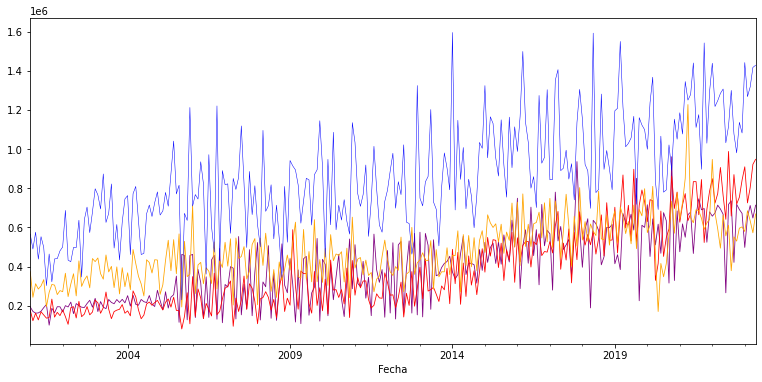

In [28]:
plt.figure(figsize=(13,6))
df_imp['Gas licuado de petróleo'].plot(color='purple', linewidth=0.8)
df_imp['Gasolina regular'].plot(color='red', linewidth=0.8)
df_imp['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_imp['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

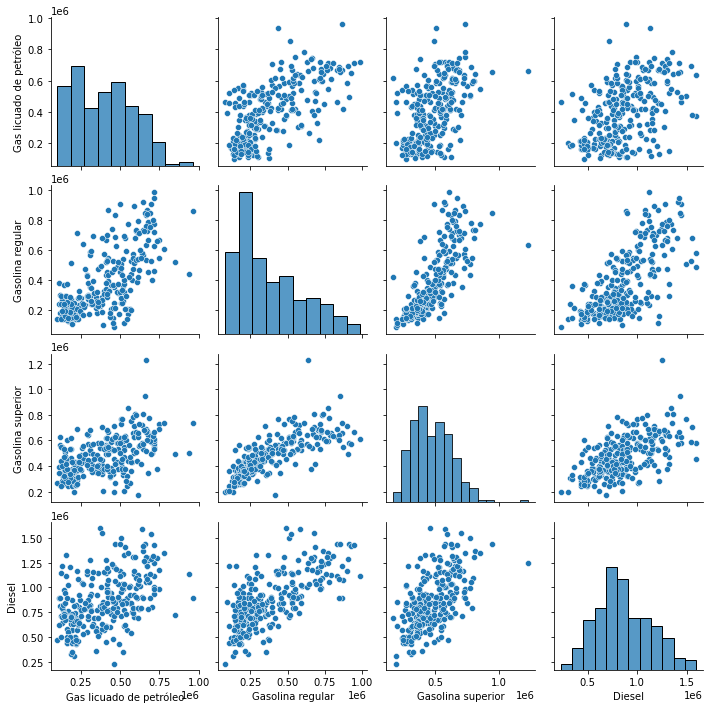

In [29]:
sns.pairplot(df_imp)
plt.show()

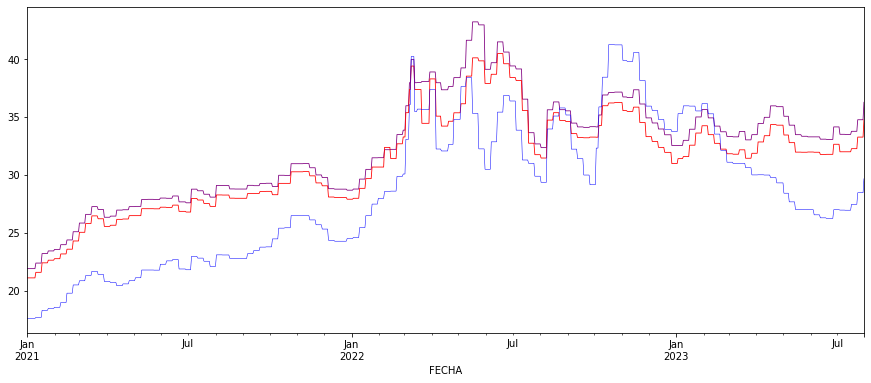

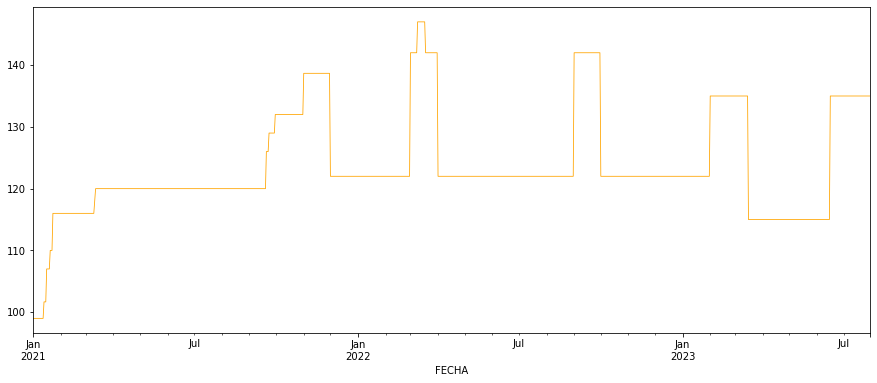

In [30]:
plt.figure(figsize=(15,6))
df_precios['Superior'].plot(color='purple', linewidth=0.8)
df_precios['Regular'].plot(color='red', linewidth=0.8)
df_precios['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

plt.figure(figsize=(15,6))
df_precios['Glp Cilindro 25Lbs.'].plot(color='orange', linewidth=0.8)
plt.show()

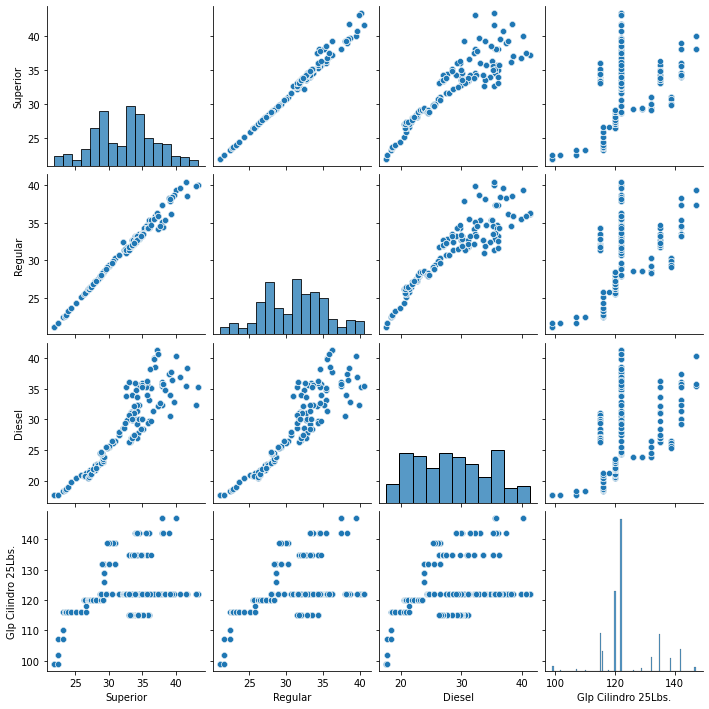

In [31]:
sns.pairplot(df_precios)
plt.show()

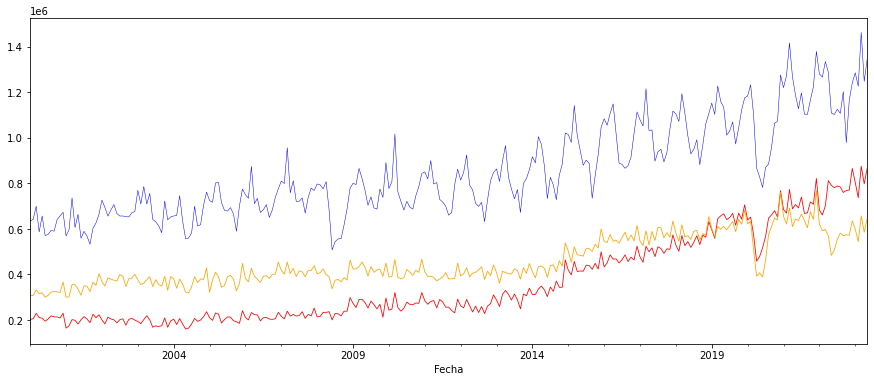

In [32]:
plt.figure(figsize=(15,6))
df_consumo['Gasolina regular'].plot(color='red', linewidth=0.8)
df_consumo['Gasolina superior'].plot(color='orange', linewidth=0.8)
df_consumo['Diesel'].plot(color='blue', linewidth=0.5)
plt.show()

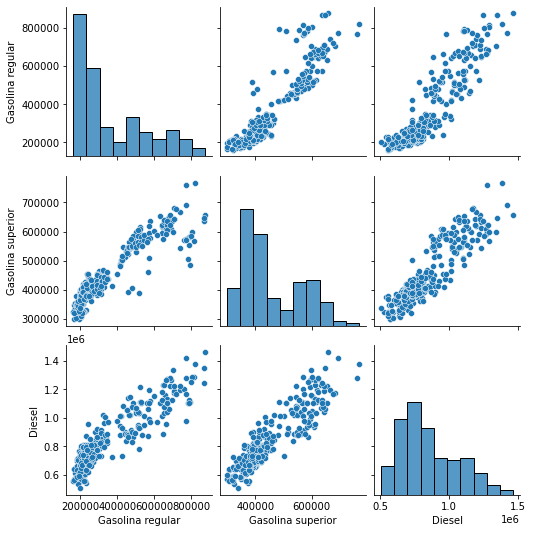

In [33]:
sns.pairplot(df_consumo)
plt.show()

# ARIMA

Hemo decidio utilizar las siguientes columnas para trabajar con arima:
- Importacion: Gas licuado de petróleo como df1
- Precios: Gasolina superior como df2
- Consumo: Diesel df3

In [34]:
df1 = df_imp['Gasolina regular']
df2 = df_precios['Superior']
df3 = df_consumo['Diesel']

In [35]:
df1.head(), df2.head(), df3.head()

(Fecha
 2001-01-01    177776.50
 2001-02-01    123115.99
 2001-03-01    161726.42
 2001-04-01    127338.74
 2001-05-01    168730.19
 Name: Gasolina regular, dtype: float64,
 FECHA
 2021-01-01    21.91
 2021-01-02    21.91
 2021-01-03    21.91
 2021-01-04    21.91
 2021-01-05    21.91
 Name: Superior, dtype: float64,
 Fecha
 2000-01-01    634667.06
 2000-02-01    642380.66
 2000-03-01    699807.25
 2000-04-01    586803.98
 2000-05-01    656948.20
 Name: Diesel, dtype: float64)

### Importacion de Gasolina regular
#### Exploracion

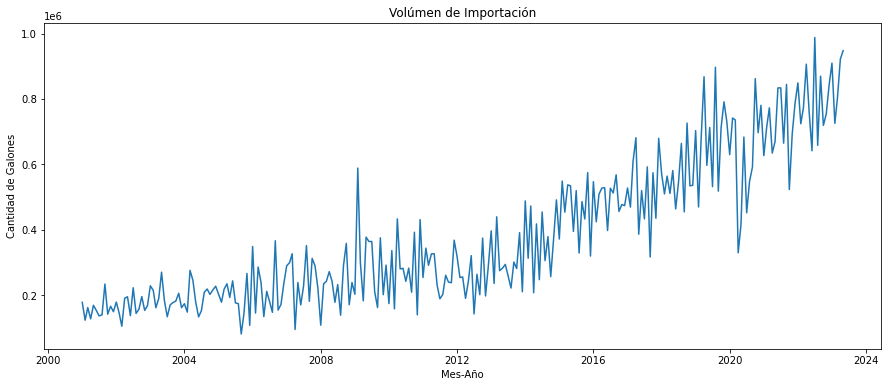

In [36]:
plt.figure(figsize=(15,6))
plt.plot(df1)
plt.gca().set(title="Volúmen de Importación", xlabel="Mes-Año", ylabel="Cantidad de Galones")
plt.show()

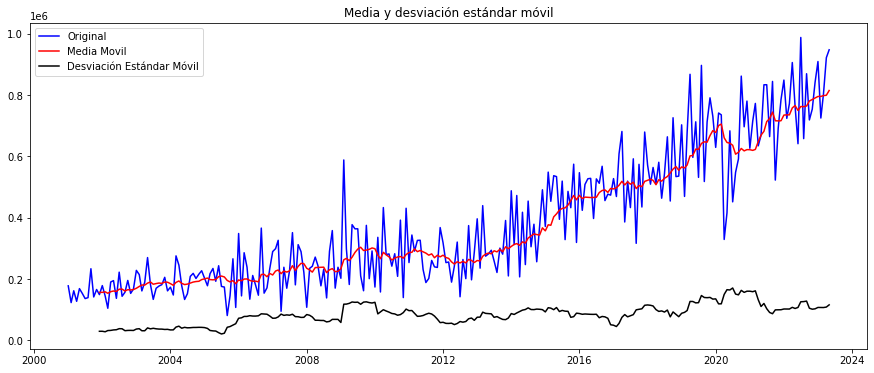

In [37]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df1.rolling(window=12).mean()
deMovil = df1.rolling(window=12).std()
# Se grafican los resultados.
plt.figure(figsize=(15,6))
original = plt.plot(df1, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

Se observa que ni la media ni la varianza son estacionarias

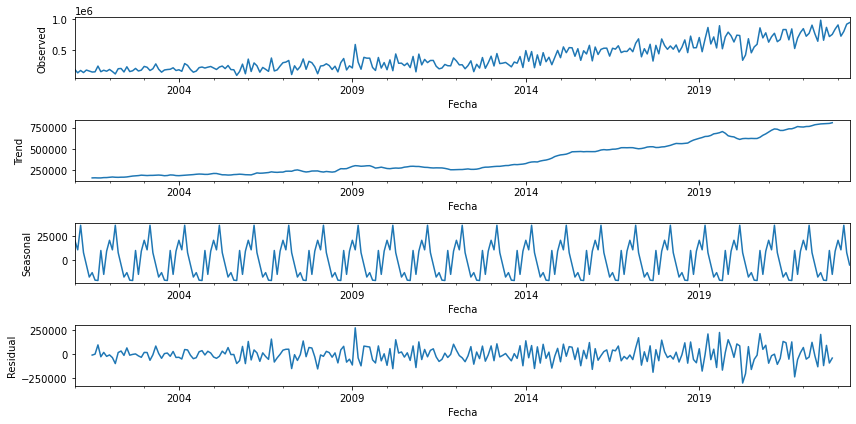

In [38]:
result = seasonal_decompose(df1)
# Create a new figure with a specific size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6))

# Plot the components on separate subplots
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

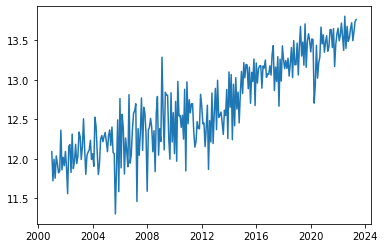

In [39]:
df1_log = np.log(df1)
plt.plot(df1_log)

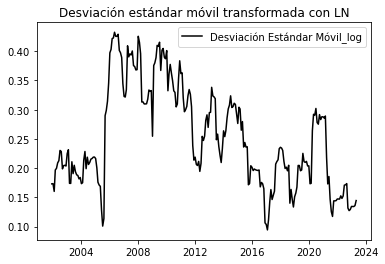

In [40]:
mediaMovil_log = df1_log.rolling(window=12).mean()
deMovil_log = df1_log.rolling(window=12).std()
#Graficando los resultados con logaritmo.
#serie_df1_log = plt.plot(df1_log, color="blue", label="df1_log")
#media_movil_df1_log = plt.plot(mediaMovil_log, color='red', label = 'Media Movil_log')
ds_log = plt.plot(deMovil_log,color='black', label = 'Desviación Estándar Móvil_log')
plt.legend(loc = 'best')
plt.title('Desviación estándar móvil transformada con LN')
plt.show(block=False)

In [41]:
print('\033[1mResultados del Test de Dickey Fuller de la serie Importación Gasolina Regular\033[0m')
df1_test = adfuller(df1, autolag='AIC')
salida_df1 = pd.Series(df1_test[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in df1_test[4].items():
        salida_df1['Critical Value (%s)'%key] = value
print(salida_df1)

Resultados del Test de Dickey Fuller de la serie Importación Gasolina Regular
Estadístico de prueba          1.090748
p-value                        0.995137
# de retardos usados           9.000000
# de observaciones usadas    259.000000
Critical Value (1%)           -3.455853
Critical Value (5%)           -2.872765
Critical Value (10%)          -2.572752
dtype: float64


In [42]:
print('\033[1mResultados del Test de Dickey Fuller para 1 diferenciación de la serie Importación Gasolina regular\033[0m')
df1_diff = df1.diff()
df1_diff.dropna(inplace=True)
df1_test = adfuller(df1_diff)
salida_df1 = pd.Series(df1_test[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in df1_test[4].items():
        salida_df1['Critical Value (%s)'%key] = value
print(salida_df1)

Resultados del Test de Dickey Fuller para 1 diferenciación de la serie Importación Gasolina regular
Estadístico de prueba       -9.852868e+00
p-value                      4.437791e-17
# de retardos usados         8.000000e+00
# de observaciones usadas    2.590000e+02
Critical Value (1%)         -3.455853e+00
Critical Value (5%)         -2.872765e+00
Critical Value (10%)        -2.572752e+00
dtype: float64


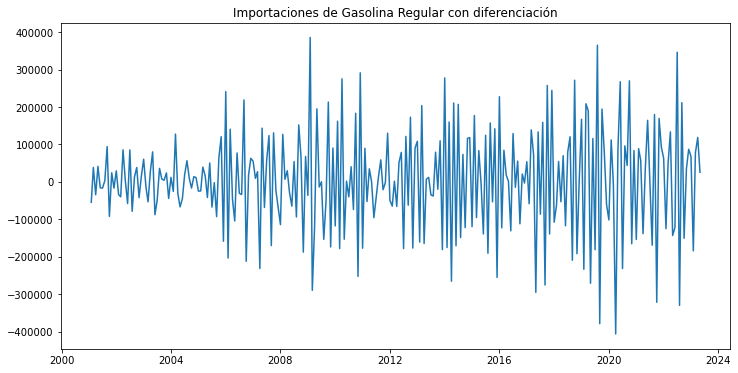

In [43]:
plt.figure(figsize=(12, 6))
plt.title('Importaciones de Gasolina Regular con diferenciación')
plt.plot(df1_diff)

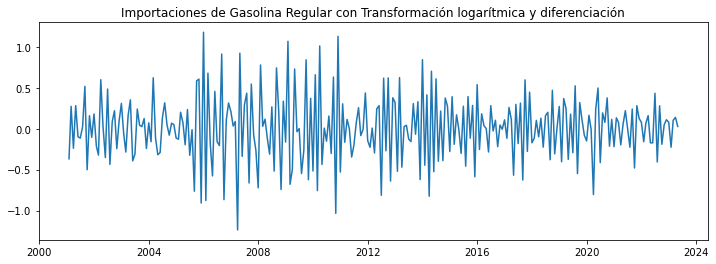

In [44]:
plt.figure(figsize=(12, 4))
df1_log_diff = df1_log.diff()
plt.title('Importaciones de Gasolina Regular con Transformación logarítmica y diferenciación')
plt.plot(df1_log_diff)

In [45]:
df1_log_diff.dropna(inplace = True)
df1_log_diff_acf = acf(df1_log_diff,nlags=5,fft=False)
df1_log_diff_pacf = pacf(df1_log_diff, nlags=36)
df1_log_diff_acf, df1_log_diff_pacf

(array([ 1.        , -0.63980275,  0.22972522, -0.1397927 ,  0.05508003,
         0.03811285]),
 array([ 1.        , -0.64219901, -0.30798694, -0.27215995, -0.25438727,
        -0.10156584, -0.04916746, -0.2515719 , -0.109741  , -0.19573169,
        -0.12725689, -0.06880904,  0.02507143, -0.17524294, -0.09741736,
        -0.05721368,  0.00913106,  0.10158407, -0.15873323, -0.15162316,
        -0.03222279, -0.0305563 ,  0.00159169, -0.04679743, -0.09825368,
        -0.12212896, -0.01962758,  0.01365864,  0.05888865, -0.03679905,
         0.09447004, -0.06584161,  0.02074825,  0.03536952, -0.24681957,
         0.1588869 ,  0.03900979]))

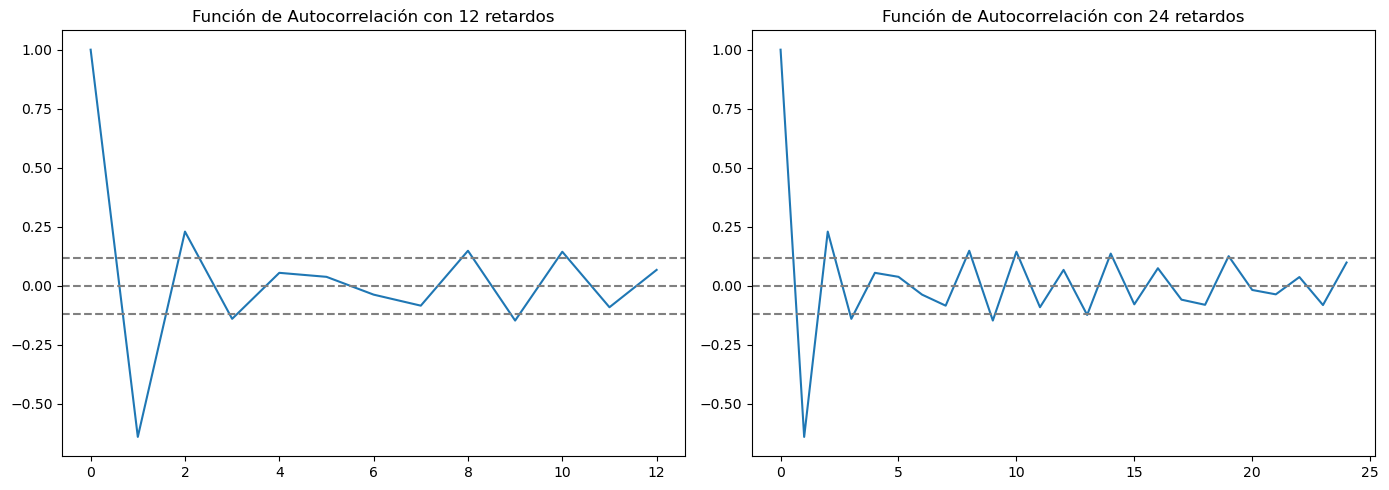

In [46]:
plt.rcParams['figure.figsize'] = [14, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(df1_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(df1_log_diff,nlags=24,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 24 retardos')

plt.tight_layout()

<Figure size 1000x600 with 0 Axes>

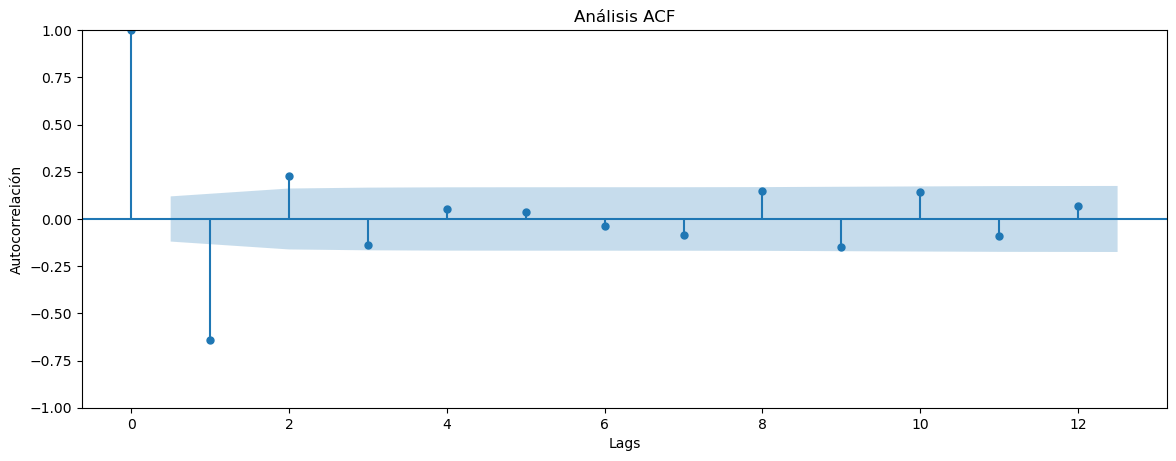

In [47]:
plt.figure(figsize=(10, 6))
plot_acf(df1_log_diff, lags=12)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.title('Análisis ACF')
plt.show()

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 5 retardos')

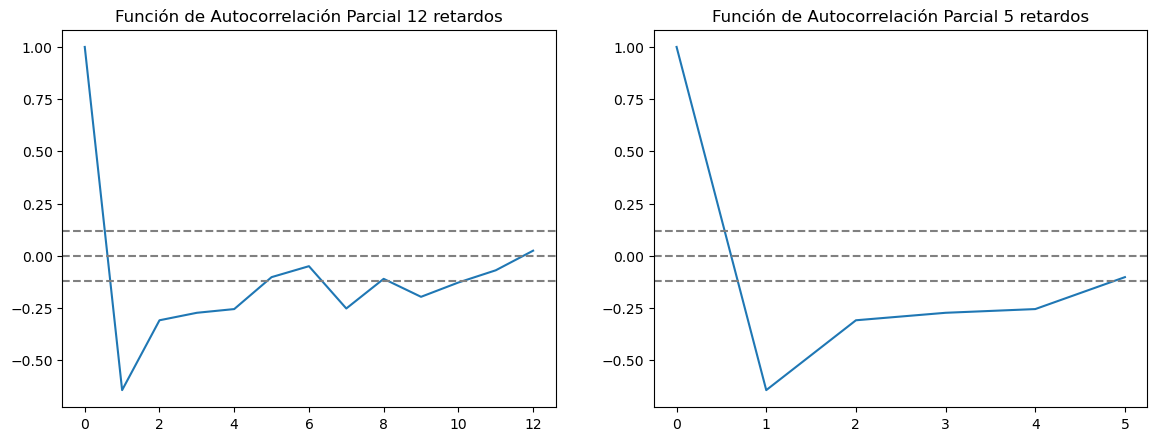

In [48]:
#plot PACF
plt.subplot(121)
plt.plot(pacf(df1_log_diff, nlags=12))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 12 retardos')

plt.subplot(122)
plt.plot(pacf(df1_log_diff, nlags=5))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df1_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 5 retardos')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

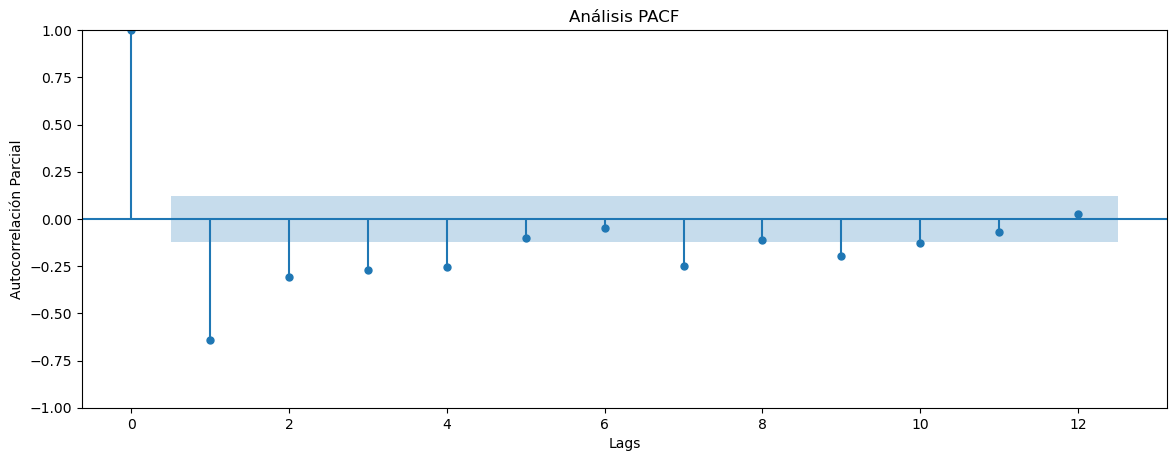

In [49]:
plt.figure(figsize=(10, 6))
plot_pacf(df1_log_diff, lags=12)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.title('Análisis PACF')
plt.show()

#### para el P podemos usar 5

No parece haber estacionalidad

In [50]:
#df1_log = df1_log.resample("M").last()
df1_modelo512 = ARIMA(df1_log, order=(5,1,2), freq ='MS')
resultado_df1_modelo512 = df1_modelo512.fit()
print(resultado_df1_modelo512.summary().tables[1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4176      1.127     -0.370      0.711      -2.627       1.792
ar.L2          0.0011      0.336      0.003      0.997      -0.657       0.660
ar.L3         -0.0622      0.111     -0.561      0.575      -0.279       0.155
ar.L4         -0.0107      0.155     -0.069      0.945      -0.314       0.292
ar.L5          0.0508      0.090      0.564      0.573      -0.126       0.228
ma.L1         -0.6447      1.128     -0.572      0.568      -2.855       1.566
ma.L2         -0.1559      0.889     -0.175      0.861      -1.898       1.586
sigma2         0.0711      0.006     12.781      0.000       0.060       0.082


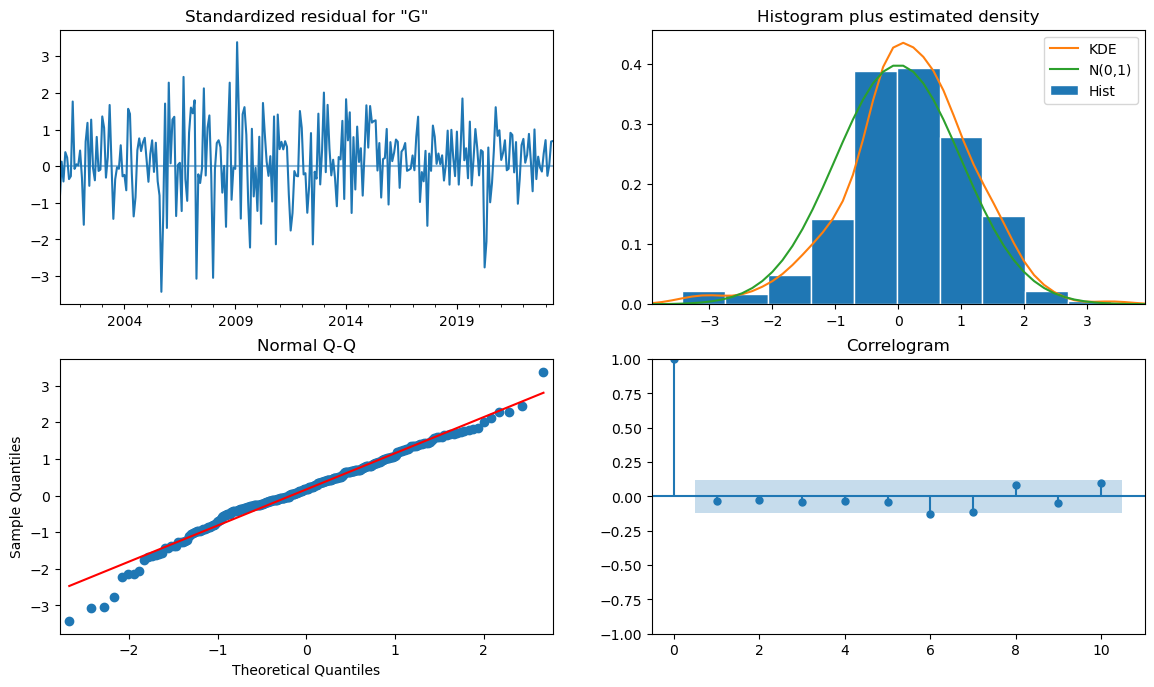

In [51]:
resultado_df1_modelo512.plot_diagnostics(figsize=(14, 8))
plt.show()

Los residuos presentan una distribución normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [52]:
df1_modelo513 = ARIMA(df1_log, order=(5,1,3), freq ='MS')
resultado_df1_modelo513 = df1_modelo513.fit()
print(resultado_df1_modelo513.summary().tables[1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1787      0.098    -12.034      0.000      -1.371      -0.987
ar.L2         -1.0688      0.159     -6.703      0.000      -1.381      -0.756
ar.L3         -0.2446      0.189     -1.295      0.195      -0.615       0.125
ar.L4         -0.0549      0.137     -0.401      0.688      -0.323       0.213
ar.L5         -0.0112      0.078     -0.143      0.886      -0.164       0.142
ma.L1          0.1467      0.084      1.752      0.080      -0.017       0.311
ma.L2          0.1211      0.078      1.549      0.121      -0.032       0.274
ma.L3         -0.7740      0.069    -11.251      0.000      -0.909      -0.639
sigma2         0.0693      0.005     12.638      0.000       0.059       0.080


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


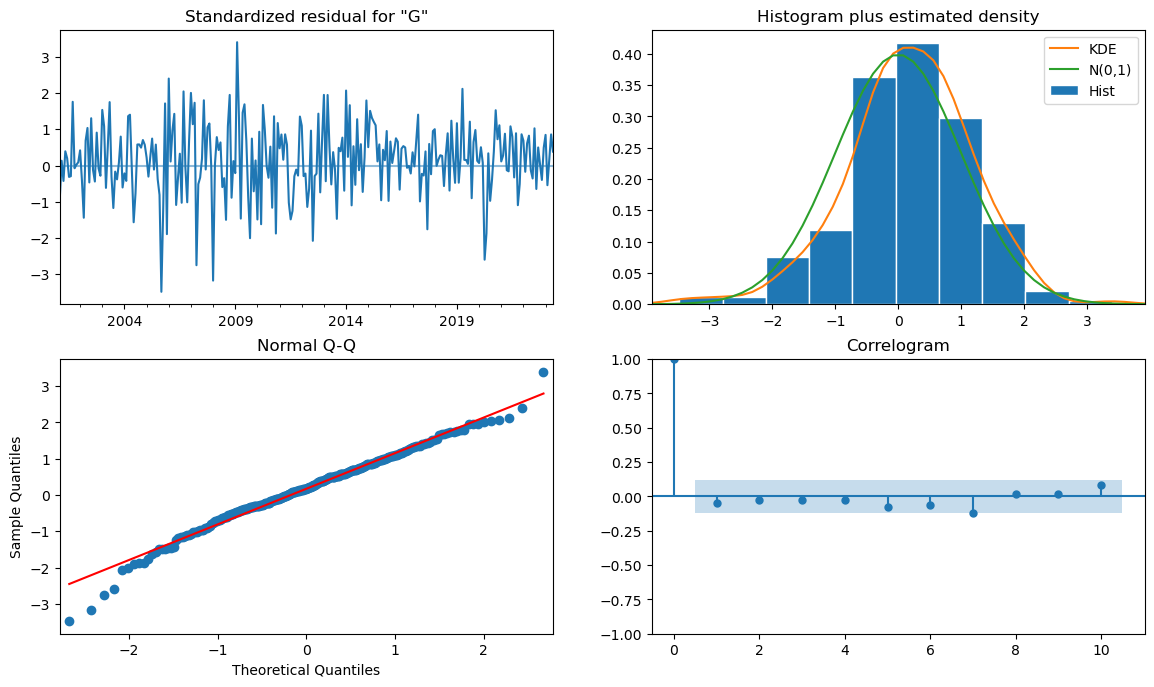

In [53]:
resultado_df1_modelo513.plot_diagnostics(figsize=(14, 8))
plt.show()

In [54]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 512=",resultado_df1_modelo512.aic)
print("Modelo 513=",resultado_df1_modelo513.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 512=",resultado_df1_modelo512.bic)
print("Modelo 513=",resultado_df1_modelo513.bic)

Resultados de AIC (Akaike information criterion)
Modelo 512= 69.58469079482742
Modelo 513= 63.007380612464054
Resultados de BIC (Bayesian information criterion)
Modelo 512= 98.31258663891427
Modelo 513= 95.32626343706175


De acuerdo a ambos indicadores es mejor el modelo p=5, d=1, q=3 por lo que este es el que será usado para predecir pues tinene un valor menor en AIC y en BIC
### Predicción Importaciones de Gasolina Regular con el mejor modelo

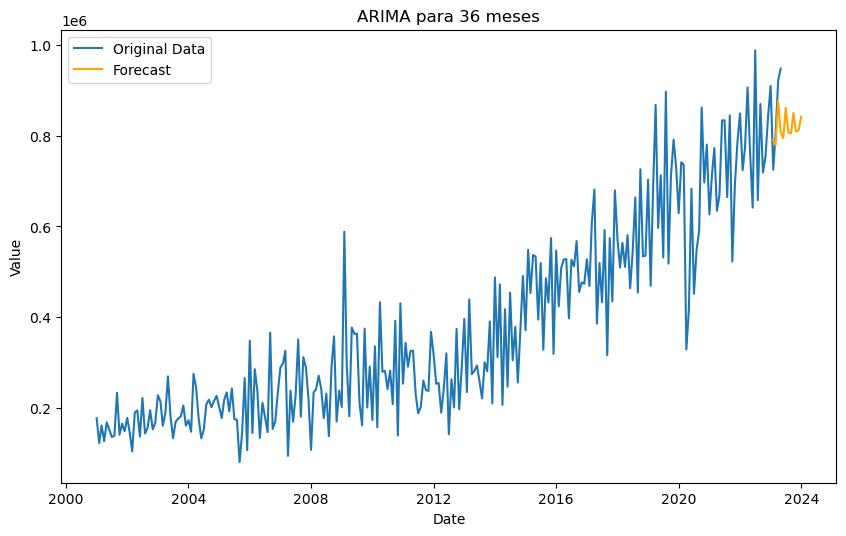

In [55]:
# Generate forecast for the next 12 months
forecast_steps = 12
forecast = resultado_df1_modelo513.forecast(steps=forecast_steps)
forecast_original_scale = np.exp(forecast)

# Create a date range for the forecasted months
last_date = df1.index[-6]  # Assuming 'df' is your original data DataFrame
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# Create a DataFrame to hold the forecasted values
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)


# Plot the original data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df1, label='Original Data')
plt.plot(forecast_df.index, forecast_original_scale, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA para 36 meses')
plt.legend()
plt.show()

### Precios de Gasolina Superior
#### Exploracion

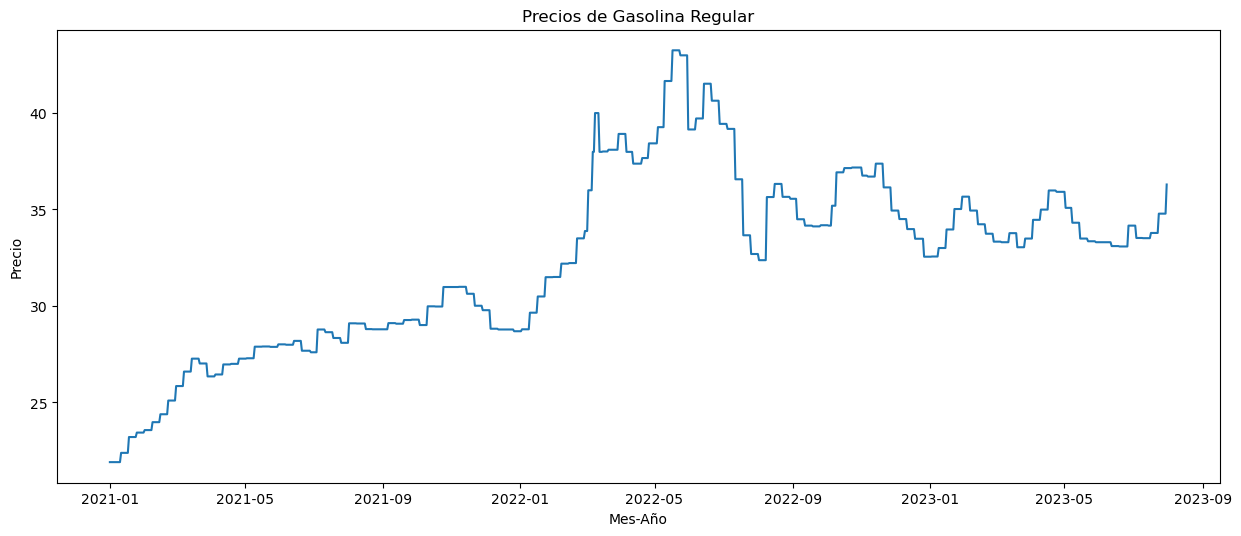

In [56]:
plt.figure(figsize=(15,6))
plt.plot(df2)
plt.gca().set(title="Precios de Gasolina Regular", xlabel="Mes-Año", ylabel="Precio")
plt.show()

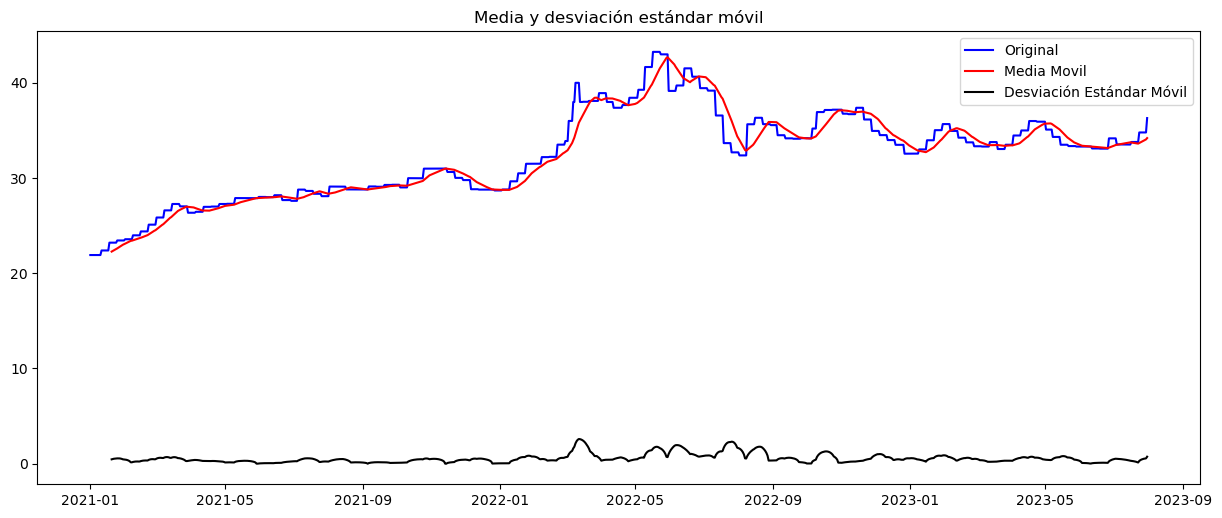

In [57]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = df2.rolling(window=20).mean()
deMovil = df2.rolling(window=20).std()
# Se grafican los resultados.
plt.figure(figsize=(15,6))
original = plt.plot(df2, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

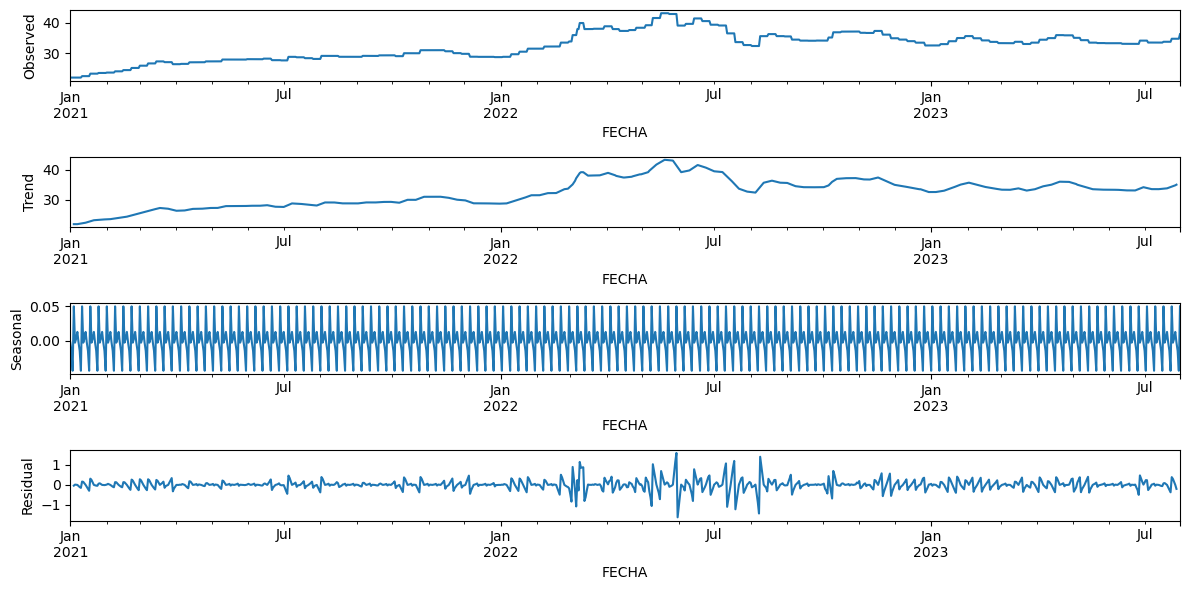

In [58]:
result = seasonal_decompose(df2)
# Create a new figure with a specific size
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6))

# Plot the components on separate subplots
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

### Consumos Gasolina Superior

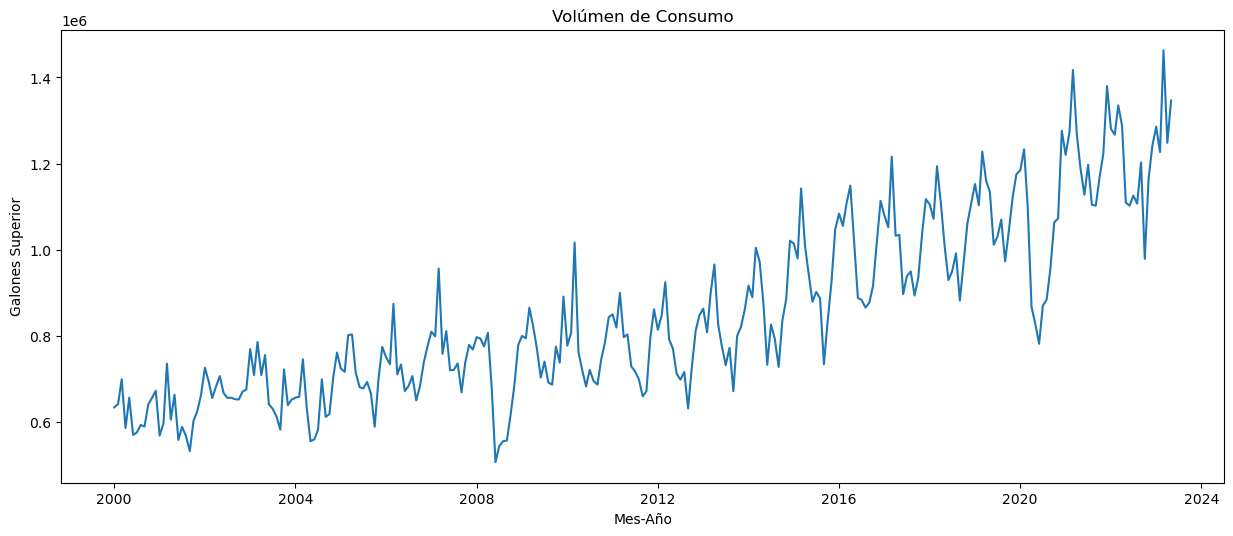

In [60]:
plt.figure(figsize=(15,6))
plt.plot(df3)
plt.gca().set(title="Volúmen de Consumo", xlabel="Mes-Año", ylabel="Galones Superior")
plt.show()

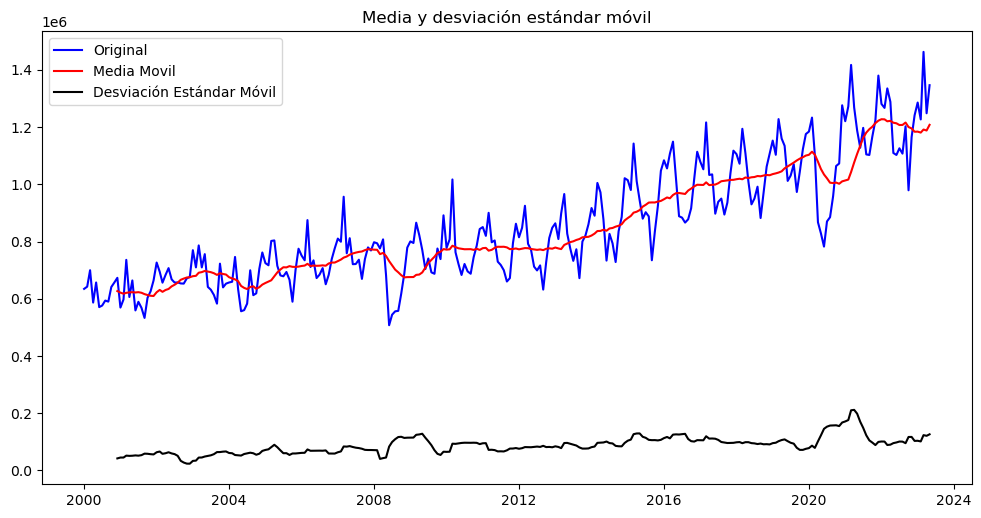

In [61]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil_df3 = df3.rolling(window=12).mean()
deMovil_df3 = df3.rolling(window=12).std()
# Se grafican los resultados.
plt.figure(figsize=(12,6))
original_df3 = plt.plot(df3, color="blue", label="Original")
media_df3 = plt.plot(mediaMovil_df3, color='red', label = 'Media Movil')
ds_df3 = plt.plot(deMovil_df3,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil')
plt.show(block=False)

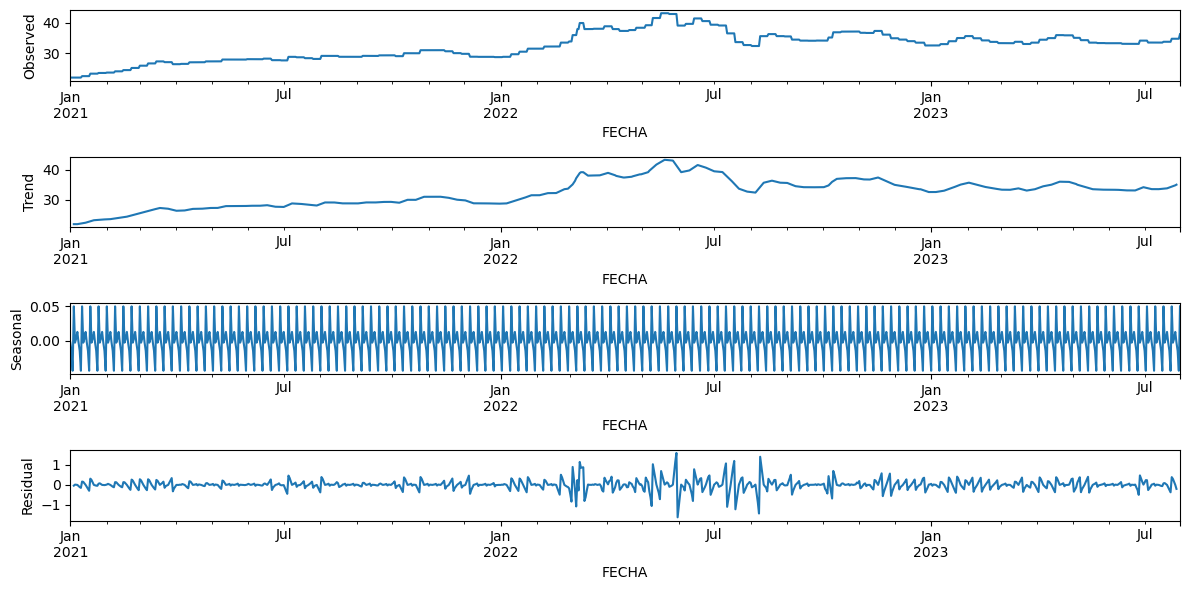

In [62]:
result_df3 = seasonal_decompose(df3)
# Create a new figure with a specific size
fig_df3, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 6))

# Plot the components on separate subplots
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

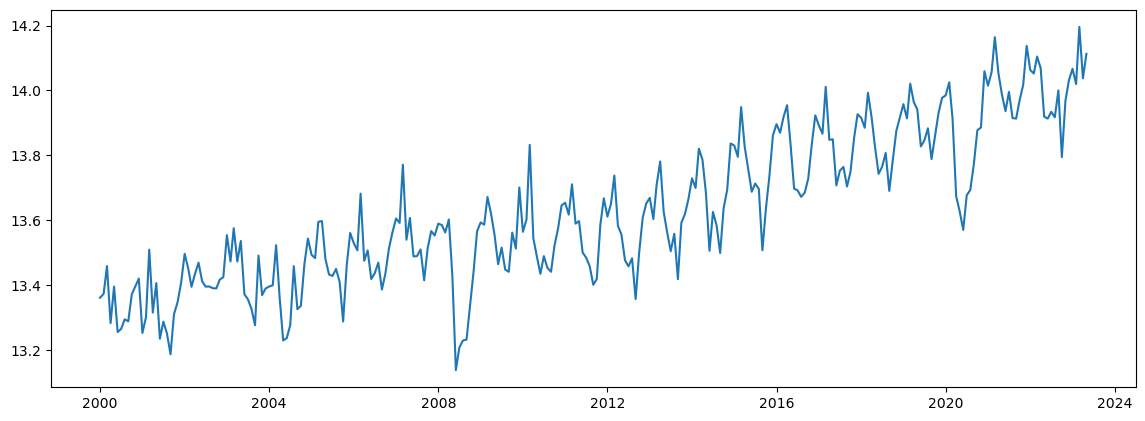

In [63]:
df3_log = np.log(df3)
plt.plot(df3_log)

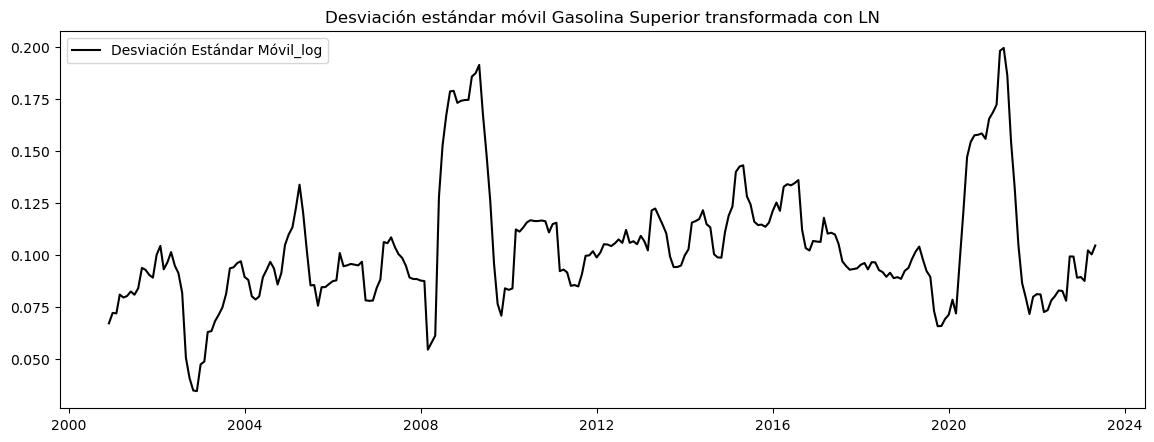

In [64]:
mediaMovil_log_df3 = df3_log.rolling(window=12).mean()
deMovil_log_df3 = df3_log.rolling(window=12).std()
#Graficando los resultados con logaritmo.
#serie_df3_log = plt.plot(df3_log, color="blue", label="df3_log")
#media_movil_df3_log = plt.plot(mediaMovil_log_df3, color='red', label = 'Media Movil_log')
ds_log = plt.plot(deMovil_log_df3,color='black', label = 'Desviación Estándar Móvil_log')
plt.legend(loc = 'best')
plt.title('Desviación estándar móvil Gasolina Superior transformada con LN')
plt.show(block=False)

Se tienen dos claros picos de la crisis del 2008 y el Covid pero en general es bastante estable

In [65]:
print('\033[1mResultados del Test de Dickey Fuller de la serie Consumo Superior\033[0m')
df3_test = adfuller(df3, autolag='AIC')
salida_df3 = pd.Series(df3_test[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in df3_test[4].items():
        salida_df3['Critical Value (%s)'%key] = value
print(salida_df3)

Resultados del Test de Dickey Fuller de la serie Consumo Superior
Estadístico de prueba          0.018032
p-value                        0.959998
# de retardos usados          12.000000
# de observaciones usadas    268.000000
Critical Value (1%)           -3.454988
Critical Value (5%)           -2.872386
Critical Value (10%)          -2.572549
dtype: float64


El valor p e mayor a 0.05 se procede a diferenciar 1 vez

In [66]:
print('\033[1mResultados del Test de Dickey Fuller para 1 diferenciación de la serie Consumo Superior\033[0m')
df3_diff = df3.diff()
df3_diff.dropna(inplace=True)
df3_test = adfuller(df3_diff)
salida_df3 = pd.Series(df3_test[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in df3_test[4].items():
        salida_df3['Critical Value (%s)'%key] = value
print(salida_df3)

Resultados del Test de Dickey Fuller para 1 diferenciación de la serie Consumo Superior
Estadístico de prueba       -6.884266e+00
p-value                      1.407679e-09
# de retardos usados         1.100000e+01
# de observaciones usadas    2.680000e+02
Critical Value (1%)         -3.454988e+00
Critical Value (5%)         -2.872386e+00
Critical Value (10%)        -2.572549e+00
dtype: float64


El p-valor es menor a 0.05 se rechaza la hipótesis nula, Ha: No hay raices unitarias se acepta

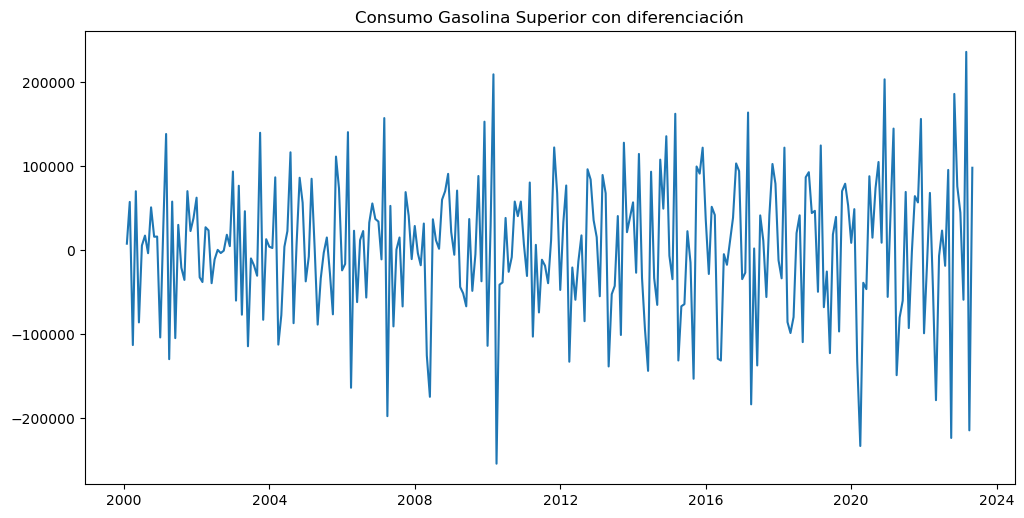

In [67]:
plt.figure(figsize=(12, 6))
plt.title('Consumo Gasolina Superior con diferenciación')
plt.plot(df3_diff)

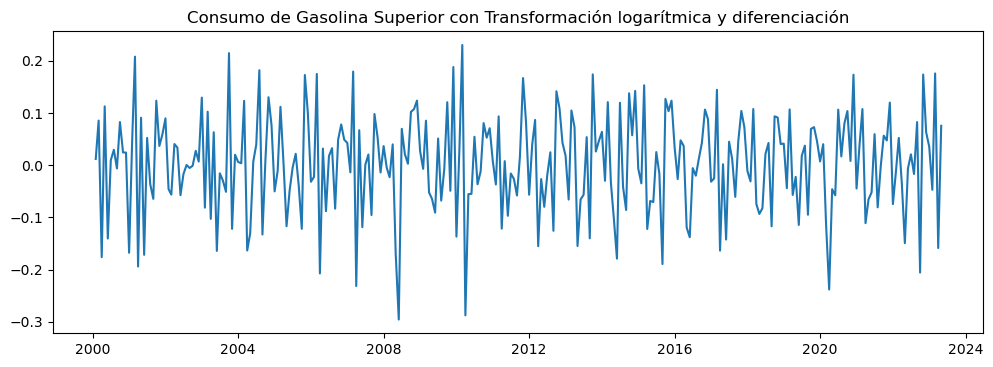

In [68]:
plt.figure(figsize=(12, 4))
df3_log_diff = df3_log.diff()
plt.title('Consumo de Gasolina Superior con Transformación logarítmica y diferenciación')
plt.plot(df3_log_diff)

In [69]:
df3_log_diff.dropna(inplace = True)
df3_log_diff_acf = acf(df3_log_diff,nlags=5,fft=False)
df3_log_diff_pacf = pacf(df3_log_diff, nlags=36)
df3_log_diff_acf, df3_log_diff_pacf

(array([ 1.        , -0.19722102,  0.02907365,  0.01670783, -0.06106934,
        -0.0078728 ]),
 array([ 1.        , -0.19792791, -0.01029599,  0.02155302, -0.05637933,
        -0.03308451, -0.46748652, -0.38169926, -0.21806094, -0.07405124,
        -0.11861396, -0.21578912,  0.23083654,  0.04752106,  0.03563811,
         0.01913844, -0.02180888, -0.02791521, -0.20400601, -0.24574491,
        -0.14732467, -0.13522994, -0.21210924, -0.03270305,  0.15932065,
        -0.06794954,  0.05472767,  0.01121561, -0.06728093,  0.07590124,
        -0.25579207, -0.12546835,  0.06216934, -0.09476825,  0.05986017,
        -0.14906471,  0.13643478]))

<Figure size 1000x600 with 0 Axes>

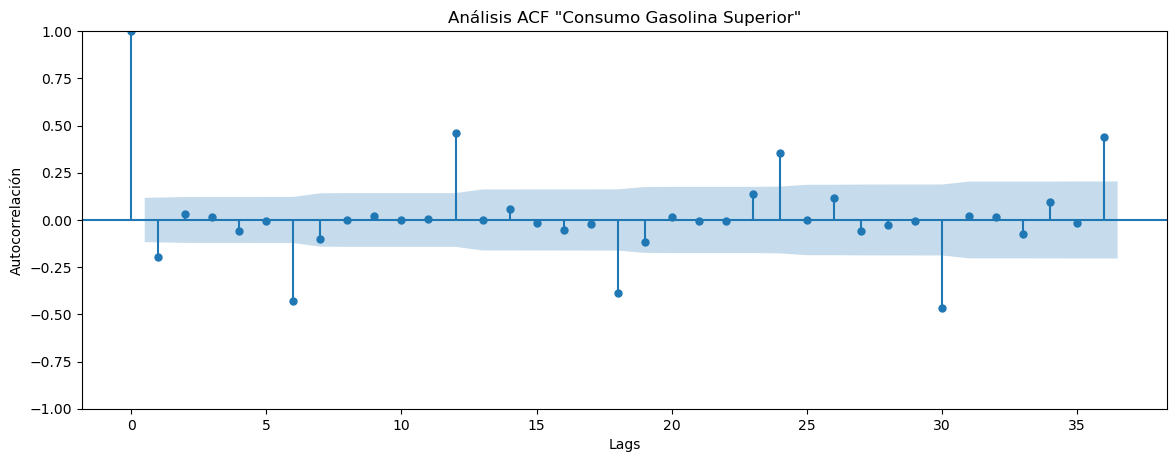

In [70]:
plt.figure(figsize=(10, 6))
plot_acf(df3_log_diff, lags=36)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación')
plt.title('Análisis ACF "Consumo Gasolina Superior"')
plt.show()

#### Se sugiere un valor de desde de 2 para el Q
Parece haber un componente de temporadas anual por las correlaciones de 12 24 y 36 meses

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

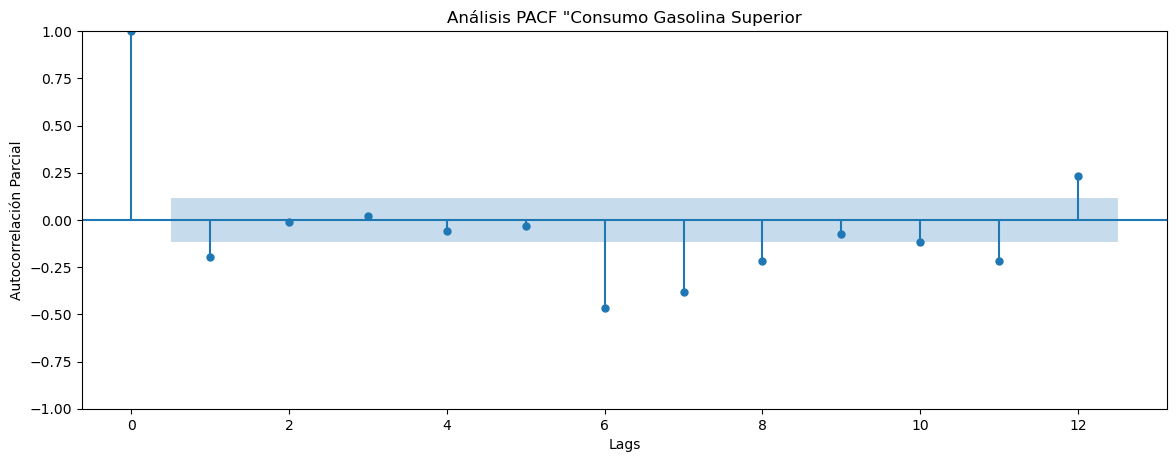

In [71]:
plt.figure(figsize=(8, 6))
plot_pacf(df3_log_diff, lags=12)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.title('Análisis PACF "Consumo Gasolina Superior')
plt.show()

#### para el P podemos usar 2 también 

In [72]:
df3_log_D = df3_log.diff(12)
df3_log_D.dropna(inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

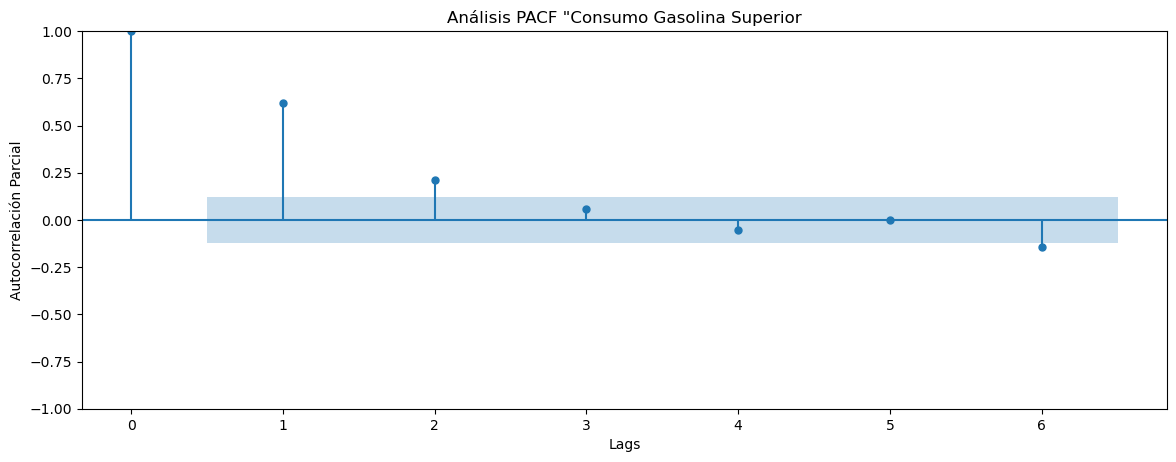

In [73]:
plt.figure(figsize=(8, 6))
plot_pacf(df3_log_D, lags=6)
plt.xlabel('Lags')
plt.ylabel('Autocorrelación Parcial')
plt.title('Análisis PACF "Consumo Gasolina Superior')
plt.show()

Luego de hacer una diferenciación estacional, podemos observar que prácticamente se anulan los coeficientes después de p=3. <br>
Probemos el siguiente componente estacional: <br>
- P = 3
- D = 1
- Q = 0

In [74]:
df3_modelo212 = SARIMAX(df3_log, order=(2,1,2), seasonal_order=(2,1,2,12), enforce_stationarity=False, enforce_invertibility=False)
df3_resultado_m212 = df3_modelo212.fit()
print(df3_resultado_m212.summary().tables[1])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8236      0.350     -2.353      0.019      -1.510      -0.138
ar.L2         -0.0574      0.159     -0.360      0.719      -0.370       0.255
ma.L1          0.8291      0.635      1.306      0.192      -0.416       2.074
ma.L2         -0.5107      0.271     -1.887      0.059      -1.041       0.020
ar.S.L12      -0.6166      0.168     -3.667      0.000      -0.946      -0.287
ar.S.L24      -0.0925      0.079     -1.164      0.244      -0.248       0.063
ma.S.L12      -0.4196      0.429     -0.977      0.328      -1.261       0.422
ma.S.L24      -0.6044      0.247     -2.449      0.014      -1.088      -0.121
sigma2         0.0025      0.003      0.964      0.335      -0.003       0.007


Análisis de residuos

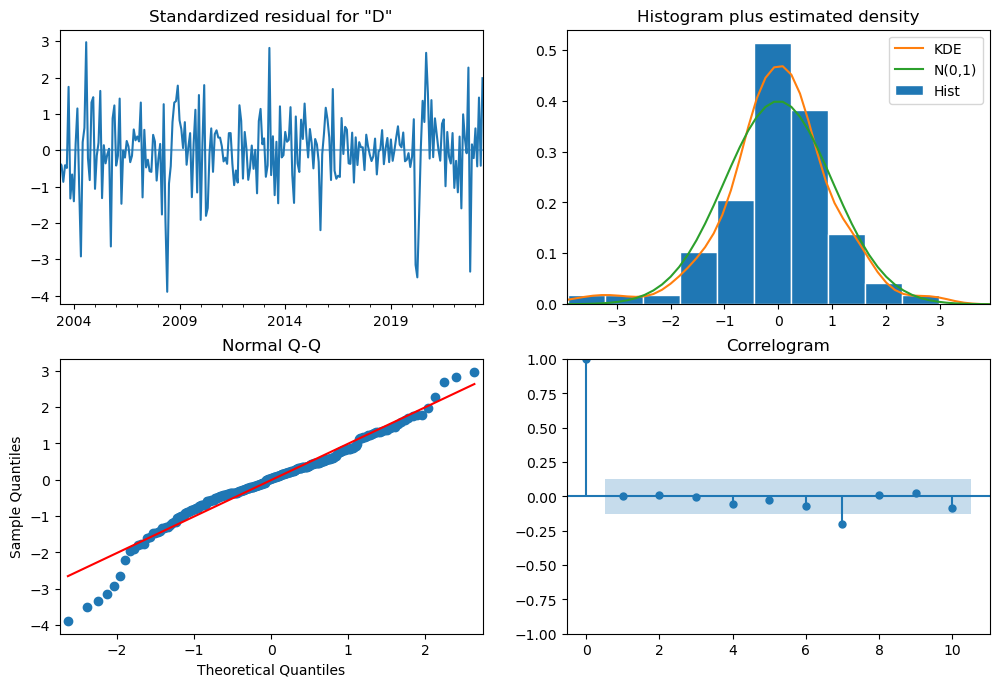

In [75]:
df3_resultado_m212.plot_diagnostics(figsize=(12, 8))
plt.show()

 Como se puede obserevar los residuos presentan una distribución masomenos normal, y parecen comportarse como un ruido blanco dado que en el correlograma no hay autocorrelaciones significativas

In [76]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 121=",df3_resultado_m212.aic)
print("Modelo 221=",df3_resultado_m212.aic)

Resultados de AIC (Akaike information criterion)
Modelo 121= -606.9069908977534
Modelo 221= -606.9069908977534


#### Predicción con el mejor modelo

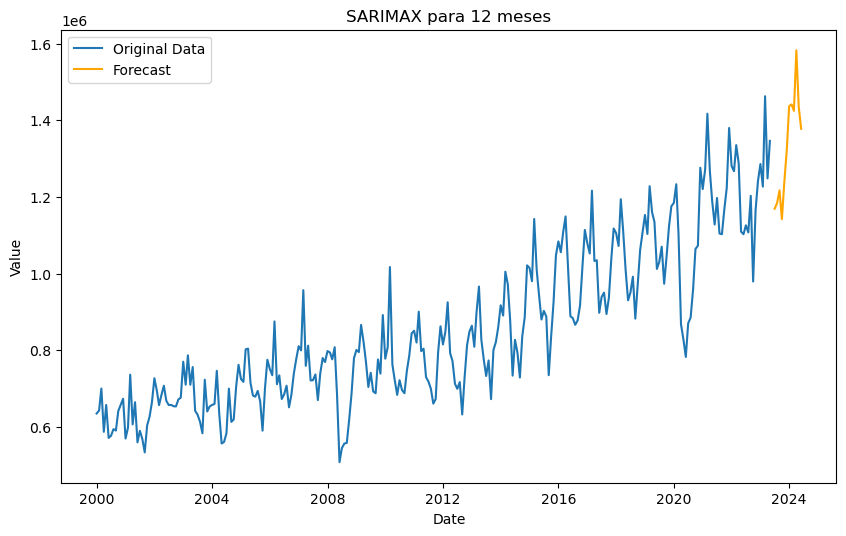

In [77]:
# Generate forecast for the next 12 months
forecast_steps = 12
forecast = df3_resultado_m212.forecast(steps=forecast_steps)
forecast_original_scale = np.exp(forecast)

# Create a date range for the forecasted months
last_date = df3.index[-1]  # Assuming 'df' is your original data DataFrame
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, freq='M')[1:]

# Create a DataFrame to hold the forecasted values
forecast_df = pd.DataFrame({'Forecast': forecast}, index=forecast_index)


# Plot the original data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(df3.index, df3.values, label='Original Data')
plt.plot(forecast_df.index, forecast_original_scale, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('SARIMAX para 12 meses')
plt.legend()
plt.show()V

## Comparacion con LSTM

### Importacion de gasolina regular 

In [100]:
# Split data into train and test sets
train_size = int(0.8 * len(df1))
train_df = df1[:train_size]
test_df = df1[train_size:]

# ARIMA model
order = (5, 1, 3)  # Example ARIMA order
arima_model = ARIMA(train_df, order=order)
arima_results = arima_model.fit()

# LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1)))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

X_train = np.array(train_df).reshape(-1, 1, 1)
y_train = np.array(train_df)

lstm_model = create_lstm_model()
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# ARIMA
arima_predictions = arima_results.forecast(steps=len(test_df))

# LSTM
lstm_predictions = []
for i in range(len(test_df)):
    lstm_input = np.array([lstm_predictions[-1]] if lstm_predictions else X_train[-1])
    lstm_pred = lstm_model.predict(lstm_input.reshape(1, 1, 1))
    lstm_predictions.append(lstm_pred[0, 0])

# Calculate RMSE and MAPE for both models
rmse_arima = np.sqrt(mean_squared_error(test_df, arima_predictions))
mape_arima = np.mean(np.abs((test_df - arima_predictions) / test_df)) * 100

rmse_lstm = np.sqrt(mean_squared_error(test_df, lstm_predictions))
mape_lstm = np.mean(np.abs((test_df - lstm_predictions) / test_df)) * 100

# Print the results
print("ARIMA - RMSE:", rmse_arima)
print("ARIMA - MAPE:", mape_arima)
print("LSTM - RMSE:", rmse_lstm)
print("LSTM - MAPE:", mape_lstm)
print("STD:", df1.std())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

1/1 [==============================] - 0s 27ms/step
ARIMA - RMSE: 200348.75221223445
ARIMA - MAPE: 23.55410108988794
LSTM - RMSE: 728429.5644768805
LSTM - MAPE: 99.99905668459381
STD: 219364.3548742019


Para esta primera serie, vemos que el rmse es significativamente mejor en el arima que el LSTM utilizado. De hecho este arima es aceptable considerando que un MAPE de 23.55% no esta nada mal considerando el valor de la varianza, ademas de que lo hicimos con el test. Por lo que utilizaremos ARIMA para predecir la 

### Precios de gasolina superior

In [104]:
# Split data into train and test sets
train_size = int(0.8 * len(df3))
train_df = df3[:train_size]
test_df = df3[train_size:]

# ARIMA model
order = (0, 1, 0)  # Example ARIMA order
arima_model = df3_modelo212 = SARIMAX(df3_log, order=(2,1,2), seasonal_order=(2,1,2,12), enforce_stationarity=False, enforce_invertibility=False)
arima_results = arima_model.fit()

# LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1)))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

X_train = np.array(train_df).reshape(-1, 1, 1)
y_train = np.array(train_df)

lstm_model = create_lstm_model()
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# ARIMA
arima_predictions = arima_results.forecast(steps=len(test_df))

# LSTM
lstm_predictions = []
for i in range(len(test_df)):
    lstm_input = np.array([lstm_predictions[-1]] if lstm_predictions else X_train[-1])
    lstm_pred = lstm_model.predict(lstm_input.reshape(1, 1, 1))
    lstm_predictions.append(lstm_pred[0, 0])

# Calculate RMSE and MAPE for both models
rmse_arima = np.sqrt(mean_squared_error(test_df, arima_predictions))
mape_arima = np.mean(np.abs((test_df - arima_predictions) / test_df)) * 100

rmse_lstm = np.sqrt(mean_squared_error(test_df, lstm_predictions))
mape_lstm = np.mean(np.abs((test_df - lstm_predictions) / test_df)) * 100

# Print the results
print("ARIMA - RMSE:", rmse_arima)
print("ARIMA - MAPE:", mape_arima)
print("LSTM - RMSE:", rmse_lstm)
print("LSTM - MAPE:", mape_lstm)
print("STD", df3.std())

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1/1 [==============================] - 0s 27ms/step
ARIMA - RMSE: 1146150.6364623634
ARIMA - MAPE: nan
LSTM - RMSE: 1146150.913747324
LSTM - MAPE: 99.99874331164558
STD 205345.61556490546


En este caso el ARIMA tiene un muy buen rendimiento en el test ya que el rmse casi 4 veces mejor que la desviacion estandar, mientras que el LSTM es simplemente aceptable. Por lo tanto nos quedaremos con el ARIMA.

### Consumos de diesel

In [ ]:
# Split data into train and test sets
train_size = int(0.8 * len(df2))
train_df = df2[:train_size]
test_df = df2[train_size:]

# ARIMA model
order = (0, 1, 0)  # Example ARIMA order
arima_model = SARIMAX(train_df, order=order)
arima_results = arima_model.fit()

# LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, input_shape=(1, 1)))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

X_train = np.array(train_df).reshape(-1, 1, 1)
y_train = np.array(train_df)

lstm_model = create_lstm_model()
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

# ARIMA
arima_predictions = arima_results.forecast(steps=len(test_df))

# LSTM
lstm_predictions = []
for i in range(len(test_df)):
    lstm_input = np.array([lstm_predictions[-1]] if lstm_predictions else X_train[-1])
    lstm_pred = lstm_model.predict(lstm_input.reshape(1, 1, 1))
    lstm_predictions.append(lstm_pred[0, 0])

# Calculate RMSE and MAPE for both models
rmse_arima = np.sqrt(mean_squared_error(test_df, arima_predictions))
mape_arima = np.mean(np.abs((test_df - arima_predictions) / test_df)) * 100

rmse_lstm = np.sqrt(mean_squared_error(test_df, lstm_predictions))
mape_lstm = np.mean(np.abs((test_df - lstm_predictions) / test_df)) * 100

# Print the results
print("ARIMA - RMSE:", rmse_arima)
print("ARIMA - MAPE:", mape_arima)
print("LSTM - RMSE:", rmse_lstm)
print("LSTM - MAPE:", mape_lstm)
print("STD", df2.std())